# Data Science / Machine Learning Meetup #1 Deep Learning Hands-on
# オルタナティブ・データと自然言語処理

## はじめに

演習の概略は以下の通りです。
1. [前処理](#前処理)
1. [モデル構築](#モデル構築)
1. [予測](#予測)


### 投資判断への自然言語処理応用の一事例としての感情分析
投資判断のために、企業の価値を考慮する際のアプローチとして、従来の枠組みにとらわれない様々な情報（オルタナティブ・データ）を用いることを考えます。

投資家の判断を左右し得る様々な情報を入力とし、投資判断のための定量的なシグナルに変換する予測モデルを構築します。
入力となるデータには様々なものがあります。以下はその例です。

- ニュース（製品のリコール、自然災害など）
- 

Deep Learningによって、入力データの形式を問わず、予測モデルを構築することができます。

ここでは、ソーシャルメディアサイトStockTwitsの投稿を使用します。StockTwitsのコミュニティは、投資家、トレーダー、起業家により利用されています。

これらのtwitをトレーニング・データとして感情のスコアを生成するモデルを構築します。

モデルの訓練のためには、入力に対応するラベルが必要になります。ラベルの精度は、モデルの訓練に当たって大変重要な要素です。

センチメントの度合いを把握するために、非常にネガティブ、ネガティブ、ニュートラル、ポジティブ、非常にポジティブという5段階のスケールを使用します。それぞれ、-2から2までの数値に対応しています。

このラベル付きデータによって訓練されたモデルを使用して、自然言語を入力として、その文章の背後にある感情を予測するモデルを構築します。

構築された予測モデルは、投資判断の１要素として、銘柄に対するコミュニティのセンチメントを判定するために用いられます。

ここでは、（主にラベルのついたデータの準備という課題をスキップするため）ソーシャルメディアの投稿を用いましたが、自然言語の解釈としては、四半期報告など、企業が発表する文章から、専門家の労力を用いずに、定量的な情報に変換するための利用などが考えられます。


## 環境準備

### パッケージのインストールとインポート

パッケージをインストールします（この処理は、プロジェクトで一度行えばよく、後から再度このファイルを使って分析する際にはスキップできます）

In [1]:
#!pip3 install ipython-sql==0.3.9
#!pip3 install PyHive==0.6.1
#!pip3 install SQLAlchemy==1.3.13
#!pip3 install thrift==0.13.0
#!pip3 install sasl==0.2.1
#!pip3 install thrift_sasl==0.3.0


!pip3 install nltk==3.4.5
!pip3 install torch==1.4.0

     |████████████████████████████████| 1.5MB 7.0MB/s eta 0:00:01
  Stored in directory: /home/cdsw/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 753.4MB 52kB/s s eta 0:00:01          | 2.2MB 11.2MB/s eta 0:01:07     |████████▊                       | 206.4MB 77.4MB/s eta 0:00:08MB/s eta 0:00:05     |███████████████████████████▏    | 640.7MB 70.2MB/s eta 0:00:02
You should consider upgrading via the 'pip install --upgrade pip' command.


上でインストールしたパッケージを含め、必要なモジュールをインポートします。

In [2]:
import json
import os
import random
import re
import subprocess
import glob
import traceback
from datetime import datetime

#from pyhive import hive
#import sqlalchemy

import sys
#from random import random
from operator import add
from pyspark.sql import SparkSession

import torch
import nltk
from torch import nn, optim
import torch.nn.functional as F

テーブルまたはリストのデータを表形式で表示するための、関数を定義します。

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_plot(list, head_count=10):

    df_s = pd.DataFrame(list)
    df_s = df_s.head(head_count)

    fig,ax = plt.subplots(figsize=((len(df_s.columns)+1)*1.2, (len(df_s)+1)*0.4))
    ax.axis('off')
    tbl = ax.table(cellText=df_s.values,
                   bbox=[0,0,1,1],
                   colLabels=df_s.columns,
                   rowLabels=df_s.index)
    # plt.savefig('table.png') #PNG画像出力
    plt.show() 

### ファイルの確認

本ワークショップでは、事前に準備してあるトレーニング・データを用いて、感情分析のためのモデル構築を実施します。

クラスターのtmpディレクトリにあるファイルを自分のプロジェクト環境にコピーします。

In [ ]:
!export HADOOP_CONF_DIR=/etc/hadoop/conf; hdfs dfs -get /tmp/output.json .

In [3]:
!ls -l | grep output.json

-rwx------ 1 cdsw cdsw 94712772 Feb 12 04:54 output.json


In [4]:
!head output.json
!tail output.json

{"data":[{"message_body":"$SPY $AMZN $MSFT $AAPL $TSLA currently using RH but wanting to switch to either think or swim or Webull. Anyone have preference?","sentiment":0},
{"message_body":"$AAPL ","sentiment":2},
{"message_body":"$AAPL ","sentiment":2},
{"message_body":"$AAPL ","sentiment":2},
{"message_body":"$AAPL ","sentiment":2},
{"message_body":"$AAPL ","sentiment":2},
{"message_body":"$AAPL ","sentiment":2},
{"message_body":"$AAPL ","sentiment":2},
{"message_body":"$AAPL ","sentiment":2},
{"message_body":"$AAPL ","sentiment":2},
{"message_body":"$ZYME Ask yourself the obvious question:   Institutions have just ponied up over $320 Million at $46.50.  Over 6.9 million shares.  Volume this morning +\\- 107,000 so far.  So who’s emotionally knee-jerk selling and who’s adding at lower prices?","sentiment":2},
{"message_body":"$ZYME Ask yourself the obvious question:   Institutions have just ponied up over $320 Million at $46.50.  Over 6.9 million shares.  Volume this morning +\\- 107,

## 前処理


### データの確認
データがどのように見えるかを確認します。

各フィールドの意味:

* `'message_body'`: メッセージ本文テキスト
* `'sentiment'`: センチメントスコア。-2から2までの５段階。0は中立。

下記のような内容になっているはずです。
```
{'data':
  {'message_body': '............................',
   'sentiment': 2},
  {'message_body': '............................',
   'sentiment': -2},
   ...
}
```

データを読み込みます。

In [5]:
with open('./output.json', 'r') as f:
    twits = json.load(f)

print(twits['data'][:10])

[{'message_body': '$SPY $AMZN $MSFT $AAPL $TSLA currently using RH but wanting to switch to either think or swim or Webull. Anyone have preference?', 'sentiment': 0}, {'message_body': '$AAPL ', 'sentiment': 2}, {'message_body': '$AAPL ', 'sentiment': 2}, {'message_body': '$AAPL ', 'sentiment': 2}, {'message_body': '$AAPL ', 'sentiment': 2}, {'message_body': '$AAPL ', 'sentiment': 2}, {'message_body': '$AAPL ', 'sentiment': 2}, {'message_body': '$AAPL ', 'sentiment': 2}, {'message_body': '$AAPL ', 'sentiment': 2}, {'message_body': '$AAPL ', 'sentiment': 2}]


データ件数の確認

In [6]:
print(len(twits['data']))

575901


In [31]:
positive_messages = [twit['message_body'] for twit in twits['data'] if twit['sentiment'] == 2]

In [37]:
print(positive_messages[:500])

['$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ', '$AAPL ',

In [27]:
negative_messages = [twit['message_body'] for twit in twits['data'] if twit['sentiment'] == -2]

### メッセージ本文とセンチメント・ラベルのリスト化

In [7]:
messages = [twit['message_body'] for twit in twits['data']]
# Since the sentiment scores are discrete, we'll scale the sentiments to 0 to 4 for use in our network
sentiments = [twit['sentiment'] + 2 for twit in twits['data']]

### データの前処理

テキストを前処理します。

本文に含まれるティッカーシンボル（「$シンボル」で示される）はセンチメントに関する情報を提供しないため削除します。
また、「@ユーザー名」で、ユーザに関する情報が記載されていますが、これもまたセンチメント情報を提供しないため、削除します。
URLも削除します。

### プリプロセス関数の定義

In [8]:
nltk.download('wordnet')

def preprocess(message):
    """
    入力として文字列を受け取り、次の操作を実行する: 
        - 全てのアルファベットを小文字に変換
        - URLを削除
        - ティッカーシンボルを削除 
        - 句読点を削除
        - 文字列をスペースで分割しトークン化する
        - シングル・キャラクターのトークンを削除
    
    パラメータ
    ----------
        message : 前処理の対象テキストメッセージ
        
    戻り値
    -------
        tokens: 前処理後のトークン配列
    """ 
    #TODO: Implement 
    
    # Lowercase the twit message
    text = message.lower()
    
    # Replace URLs with a space in the message
    text = re.sub("http(s)?://([\w\-]+\.)+[\w-]+(/[\w\- ./?%&=]*)?",' ', text)
    
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub("\$[^ \t\n\r\f]+", ' ', text)
    
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    text = re.sub("@[^ \t\n\r\f]+", ' ', text)

    # Replace everything not a letter with a space
    text = re.sub("[^a-z]", ' ', text)
    
    
    # Tokenize by splitting the string on whitespace into a list of words
    tokens = text.split()

    # Lemmatize words using the WordNetLemmatizer. You can ignore any word that is not longer than one character.
    wnl = nltk.stem.WordNetLemmatizer()
    tokens = [wnl.lemmatize(w, pos='v') for w in tokens if len(w) > 1]
    
    return tokens

[nltk_data] Downloading package wordnet to /home/cdsw/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Twitsメッセージ前処理
上記で定義した`preprocess`関数を全てStockTwitメッセージ・データに適用します。

※この処理には、データのサイズに応じて多少時間がかかります。

In [9]:
tokenized = list(map(preprocess, messages))

print(tokenized[:3])
print(len(tokenized))

[['currently', 'use', 'rh', 'but', 'want', 'to', 'switch', 'to', 'either', 'think', 'or', 'swim', 'or', 'webull', 'anyone', 'have', 'preference'], [], []]
575901


### Bag of Words

すべてのメッセージがトークン化されたので、ボキャブラリ（語彙）データを作成します。
その際に、コーパス全体で各単語が出現する頻度をカウントします
（[`Counter`](https://docs.python.org/3.1/library/collections.html#collections.Counter)関数を利用）。

※この処理には、データのサイズに応じて多少時間がかかります。

In [10]:
from collections import Counter

#words = []
#for tokens in tokenized:
#    for token in tokens:
#        words.append(token)
out_list = tokenized
words = [element for in_list in out_list for element in in_list]

print(words[:13])
print(len(words))

"""
Create a vocabulary by using Bag of words
"""

word_counts = Counter(words)
sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
vocab_to_int = {word:ii for ii, word in int_to_vocab.items()}

bow = []
for tokens in tokenized:
    bow.append([vocab_to_int[token] for token in tokens])

print(len(bow))
print(bow[:3])

# This BOW will not be used because it is not filtered to eliminate common words.

['currently', 'use', 'rh', 'but', 'want', 'to', 'switch', 'to', 'either', 'think', 'or', 'swim', 'or']
7449017
575901
[[712, 561, 3243, 89, 295, 3, 2268, 3, 791, 135, 67, 1801, 67, 3244, 675, 25, 3245], [], []]


### 単語の重要性（メッセージに現れる頻度）に応じた調整

ボキャブラリーを使用して、「the」、「and」、「it」などの最も一般的な単語の一部を削除します。
これらの単語は非常に一般的であるため、センチメントを特定する目的に寄与せず、ニューラルネットワークへの入力のノイズとなります。これらを除外することで、ネットワークの学習時間を短縮することができます。

また、非常に稀にしか用いられない単語も削除します。
ここでは、各単語のカウントをメッセージの数で除算する必要があります。

次に、メッセージのごく一部にしか表示されない単語を削除します。

In [12]:
"""
Set the following variables:
    freqs
    low_cutoff
    high_cutoff
    K_most_common
"""

print("len(sorted_vocab):",len(sorted_vocab))
print("sorted_vocab - top:", sorted_vocab[:3])
print("sorted_vocab - least:", sorted_vocab[-15:])

# Dictionart that contains the Frequency of words appearing in messages.
# The key is the token and the value is the frequency of that word in the corpus.
total_count = len(words)
freqs = {word: count/total_count for word, count in word_counts.items()}

#print("freqs[supplication]:",freqs["supplication"] )
print("freqs[the]:",freqs["the"] )

"""
This was the post by Ricardo:

there's no exact value for low_cutoff and high_cutoff, 
however I'd recommend you to use 
a low_cutoff that's around 0.000002 and 0.000007 
(This depends on the values you get from your freqs calculations) and 
a high_cutofffrom 5 to 20 (this depends on the most_common values from the bow).
"""

# Float that is the frequency cutoff. Drop words with a frequency that is lower or equal to this number.
low_cutoff = 0.000002

# Integer that is the cut off for most common words. Drop words that are the `high_cutoff` most common words.
"""
example_count = []
example_count.append(sorted_vocab.index("the"))
example_count.append(sorted_vocab.index("for"))
example_count.append(sorted_vocab.index("of"))
print(example_count)
high_cutoff = min(example_count)
"""
high_cutoff = 20
print("high_cutoff:",high_cutoff)
print("low_cutoff:",low_cutoff)

# The k most common words in the corpus. Use `high_cutoff` as the k.
#K_most_common = [word for word in sorted_vocab[:high_cutoff]]
K_most_common = sorted_vocab[:high_cutoff]

print("K_most_common:",K_most_common)


filtered_words = [word for word in freqs if (freqs[word] > low_cutoff and word not in K_most_common)]

print("len(filtered_words):",len(filtered_words)) 

len(sorted_vocab): 5849
sorted_vocab - top: ['the', 'be', 'of']
sorted_vocab - least: ['reek', 'hahahahaha', 'god', 'rumor', 'otl', 'unless', 'spec', 'mouse', 'supplement', 'issuance', 'institutions', 'ponied', 'emotionally', 'knee', 'jerk']
freqs[the]: 0.027184794987043258
high_cutoff: 20
low_cutoff: 2e-06
K_most_common: ['the', 'be', 'of', 'to', 'amp', 'utm', 'in', 'for', 'and', 'on', 'file', 'form', 'stock', 'share', 'by', 'sec', 'at', 'earn', 'report', 'this']
len(filtered_words): 5829


##  データ探索

### 一般的な単語

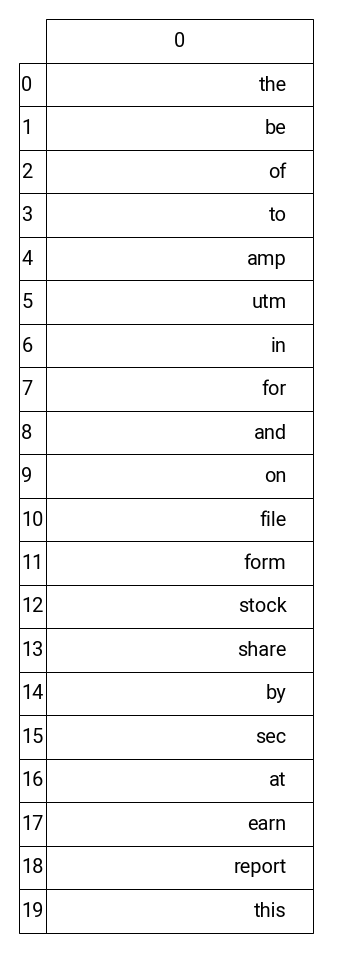

In [91]:
show_plot(K_most_common, head_count=20)

### センチメント毎の頻出単語

In [59]:
def convert_to_sorted_vocab(messages):
    words = [word for message in messages for word in message]

    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)

    return sorted_vocab

In [61]:
# Dictionart that contains the Frequency of words appearing in messages.
# The key is the token and the value is the frequency of that word in the corpus.
def filter_words(sorted_vocab, freqs):

    low_cutoff = 0.000002

    high_cutoff = 20

    K_most_common = sorted_vocab[:high_cutoff]

    filtered_words = [word for word in freqs if (freqs[word] > low_cutoff and word not in K_most_common)]
    
    return filtered_words


In [101]:
negative_messages = [twit['message_body'] for twit in twits['data'] if twit['sentiment'] == -2]
negative_tokenized = list(map(preprocess, negative_messages))
negative_sorted_vocab = convert_to_sorted_vocab(negative_tokenized)

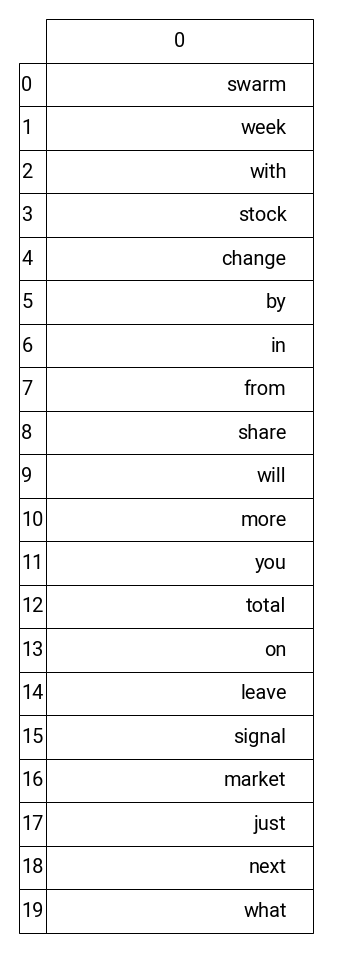

In [98]:
show_plot(negative_sorted_vocab[20:], head_count=20)

In [102]:
positive_messages = [twit['message_body'] for twit in twits['data'] if twit['sentiment'] == 2]
positive_tokenized = list(map(preprocess, positive_messages))
positive_sorted_vocab = convert_to_sorted_vocab(positive_tokenized)

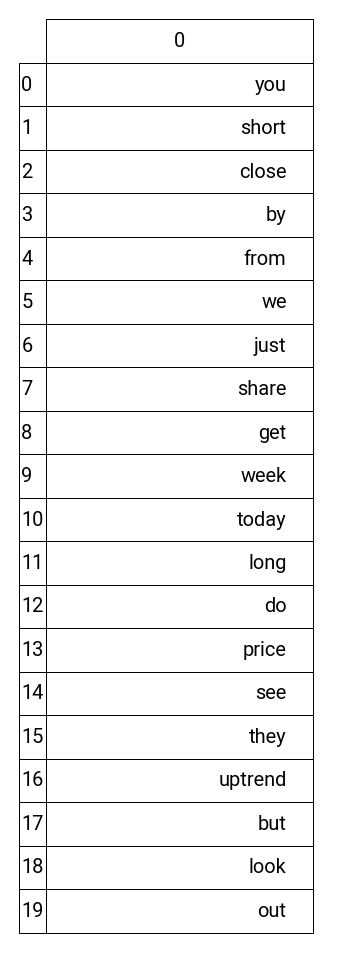

In [103]:
show_plot(positive_sorted_vocab[20:], head_count=20)

### フィルターされた単語を削除して語彙を更新
3つの変数を作成します。

In [50]:
"""
Set the following variables:
    vocab
    id2vocab
    filtered
"""

# A dictionary for the `filtered_words`. The key is the word and value is an id that represents the word. 
vocab =  {word:ii for ii, word in enumerate(filtered_words)}
# Reverse of the `vocab` dictionary. The key is word id and value is the word. 
id2vocab = {ii:word for word, ii in vocab.items()}
# tokenized with the words not in `filtered_words` removed.

print("len(tokenized):", len(tokenized))

filtered = [[token for token in tokens if token in vocab] for tokens in tokenized]
print("len(filtered):", len(filtered))
print("tokenized[:1]", tokenized[:1])
print("filtered[:1]",filtered[:1])

len(tokenized): 575901
len(filtered): 575901
tokenized[:1] [['currently', 'use', 'rh', 'but', 'want', 'to', 'switch', 'to', 'either', 'think', 'or', 'swim', 'or', 'webull', 'anyone', 'have', 'preference']]
filtered[:1] [['currently', 'use', 'rh', 'but', 'want', 'switch', 'either', 'think', 'or', 'swim', 'or', 'webull', 'anyone', 'have', 'preference']]


### 分類クラス間のバランス

訓練データのラベルには、一般に偏りがあることがよく見受けられます（例外的なデータは少ない）。
例えば、データの50％がニュートラルであること場合、毎回0（ニュートラル）を予測するだけで、ネットワークの精度が50％になることを意味します。

ネットワークが適切に学習できるように、クラスのバランスを取る必要があります。つまり、それぞれのセンチメントスコアがデータにほぼ同じ頻度で表含まれていることが望ましいと言えます。

ここでは、中立的な感情を持つデータを全体の20%になるように、ランダムにドロップします。

データに含まれるニュートラルデータのパーセンテージと、データ削除により期待されるパーセンテージの値を使って、
データをドロップする確率を求めます。

同時に、長さが0のメッセージを削除します。

In [51]:
balanced = {'messages': [], 'sentiments':[]}

n_neutral = sum(1 for each in sentiments if each == 2)
N_examples = len(sentiments)

keep_prob = (N_examples - n_neutral)/4/n_neutral

print("keep prob:", keep_prob)

for idx, sentiment in enumerate(sentiments):
    message = filtered[idx]
    if len(message) == 0:
        # skip this message because it has length zero
        continue
    elif sentiment != 2 or random.random() < keep_prob:
        balanced['messages'].append(message)
        balanced['sentiments'].append(sentiment) 

keep prob: 0.056004131765926106


バランスされたデータ中、センチメントが「ニュートラル」であるデータの割合を確認します。

In [52]:
n_neutral = sum(1 for each in balanced['sentiments'] if each == 2)
N_examples = len(balanced['sentiments'])
n_neutral/N_examples

0.21240871667483613

ボキャブラリ・ファイルを保存します。このファイルは、予測の際に、入力を変換するために必要になります。

In [13]:
import pickle

with open('vocab.pickle', 'wb') as f:
    pickle.dump(vocab, f)

## モデルの構築

これでボキャブラリーができたので、トークンをIDに変換し、それをネットワークに渡すことができます。ネットワークを定義します

下記は、ネットワークの概要です：

#### Embed -> RNN -> Dense -> Softmax

### SentimentClassifier (感情分類器)実装

クラスは、3つの主要な部分で構成されています：: 

1. init function `__init__` 
2. forward pass `forward`  
3. hidden state `init_hidden`. 

出力層では、softmaxを使用します。出力フォーマットによって出力層を選択します。（例えば、出力が２値/バイナリであれば、シグモイド関数）

このネットワークでは、センチメントスコアには5つのクラスがあるためsoftmaxが適しています。

In [14]:
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model by setting up the layers.
        
        Parameters
        ----------
            vocab_size : The vocabulary size.
            embed_size : The embedding layer size.
            lstm_size : The LSTM layer size.
            output_size : The output size.
            lstm_layers : The number of LSTM layers.
            dropout : The dropout probability.
        """
        
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout
        

        self.embedding = nn.Embedding(self.vocab_size, self.embed_size)
        self.lstm = nn.LSTM(self.embed_size, self.lstm_size, self.lstm_layers, dropout=self.dropout)
        
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)


    def init_hidden(self, batch_size):
        """ 
        Initializes hidden state
        
        Parameters
        ----------
            batch_size : The size of batches.
        
        Returns
        -------
            hidden_state
            
        """
        
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # 隠れ層として、n_layers x batch_size x hidden_dimの構造を持つテンソルを二つ作成し、ゼロで初期化
        # initialized to zero, for hidden state and cell state of LSTM
        
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.lstm_layers, batch_size,self.lstm_size).zero_(),
                         weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        return hidden


    def forward(self, nn_input, hidden_state):
        """
        Perform a forward pass of our model on nn_input.
        
        Parameters
        ----------
            nn_input : The batch of input to the NN.
            hidden_state : The LSTM hidden state.

        Returns
        -------
            logps: log softmax output
            hidden_state: The new hidden state.

        """
        
        batch_size = nn_input.size(0)
        
        # embed
        embeds = self.embedding(nn_input)
        
        # LSTM
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        
        """
        remember here you do not have batch_first=True, 
        so accordingly shape your input. 
        Moreover, since now input is seq_length x batch you just need to transform lstm_out = lstm_out[-1,:,:].
        you don't have to use batch_first=True in this case, 
        nor reshape the outputs with .view just transform your lstm_out as advised and you should be good to go.
        """
        #lstm_out = lstm_out.contiguous().view(-1, self.lstm_size)    
        lstm_out = lstm_out[-1,:,:]
        
        # dropout
        out = self.dropout(lstm_out)
        
        # Dense Layer (nn.Linear) RNNの隠れ層から値を予測
        out = self.fc(out)
        
        # Softmax関数
        logps = self.softmax(out)
        
        
        return logps, hidden_state

### モデルの確認

In [15]:
model = SentimentClassifier(len(vocab), 10, 6, 5, dropout=0.1, lstm_layers=2)
model.embedding.weight.data.uniform_(-1, 1)
input = torch.randint(0, 1000, (5, 4), dtype=torch.int64)
batch_size = 4
hidden = model.init_hidden(4)

logps, _ = model.forward(input, hidden)
print(logps)

tensor([[-1.4577, -1.7675, -1.4326, -1.6824, -1.7611],
        [-1.4568, -1.7760, -1.4235, -1.6869, -1.7618],
        [-1.4543, -1.7657, -1.4373, -1.6784, -1.7653],
        [-1.4654, -1.7506, -1.4481, -1.6645, -1.7659]],
       grad_fn=<LogSoftmaxBackward>)


### DataLoaderとバッチ処理
ここで、データをループするために使用できるジェネレーターを構築します。

効率化のため、シーケンスをバッチとして渡します。

入力テンソルは次のような形になります：(sequence_length, batch_size)

したがって、シーケンスが40トークンで、25シーケンスを渡す場合、入力サイズは(40, 25)になります。

シーケンスの長さを40に設定した場合、40トークンより多いまたは少ないメッセージは、以下のように処理します。
- 40トークン未満のメッセージの場合、足りない部分は先頭からゼロを埋め込む。
   - データを処理する前にRNNが何も開始しないように、先頭にを空欄を配置します。
   - メッセージに20個のトークンがある場合、最初の20個のスポットは0になる。
- メッセージに40個を超えるトークンがある場合、最初の40個のトークンを保持。

In [16]:
#def dataloader(messages, labels, sequence_length=30, batch_size=32, shuffle=False):
def dataloader(messages, labels, sequence_length=20, batch_size=32, shuffle=False):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # Left pad!
            start_idx = max(sequence_length - len(token_tensor), 0)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        
        yield batch, label_tensor

### トークンIDの作成

トレーニングに用いるメッセージに含まれる単語を、辞書を使ってID（数値）に変換します。この処理は、ニューラルネットワークの入力として用いるために必要です。

In [53]:
token_ids = [[vocab[word] for word in message] for message in balanced['messages']]
sentiments = balanced['sentiments']

In [55]:
print(token_ids[:10])

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 10, 11, 12, 13], [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 3, 29, 30, 31, 32, 33, 34, 35, 28, 36, 34, 37], [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 3, 29, 30, 31, 32, 33, 34, 35, 28, 36, 34, 37], [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 3, 29, 30, 31, 32, 33, 34, 35, 28, 36, 34, 37], [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 3, 29, 30, 31, 32, 33, 34, 35, 28, 36, 34, 37], [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 3, 29, 30, 31, 32, 33, 34, 35, 28, 36, 34, 37], [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 3, 29, 30, 31, 32, 33, 34, 35, 28, 36, 34, 37], [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 3, 29, 30, 31, 32, 33, 34, 35, 28, 36, 34, 37], [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 3, 29, 30, 31, 32, 33, 34, 35, 28, 36, 34, 37], [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 3, 29, 30, 31, 

###  データの分割（訓練用と検証用）

In [17]:
"""
Split data into training and validation datasets. Use an appropriate split size.
The features are the `token_ids` and the labels are the `sentiments`.
"""   

split_frac = 0.98 # for small data
#split_frac = 0.8 # for big data

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(token_ids)*split_frac)
train_features, remaining_features = token_ids[:split_idx], token_ids[split_idx:]
train_labels, remaining_labels = sentiments[:split_idx], sentiments[split_idx:]

test_idx = int(len(remaining_features)*0.5)
valid_features, test_features = remaining_features[:test_idx], remaining_features[test_idx:]
valid_labels, test_labels = remaining_labels[:test_idx], remaining_labels[test_idx:]

### トレーニング

#### トレーニング準備

利用可能なデバイス(CUDA/GPUまたはGPU)を確認します。

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [19]:
#model = SentimentClassifier(len(vocab)+1, 200, 128, 5, dropout=0.)
model = SentimentClassifier(len(vocab)+1, 1024, 512, 5, lstm_layers=2, dropout=0.2)
model.embedding.weight.data.uniform_(-1, 1)
model.to(device)

SentimentClassifier(
  (embedding): Embedding(5645, 1024)
  (lstm): LSTM(1024, 512, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=5, bias=True)
  (softmax): LogSoftmax()
)

#### トレーニング実施

トレーニングを実行します。モデルの訓練の進行度合を確認するために、定期的にLossを出力します。

※この処理には、データのサイズに応じて、十分な時間が必要です。

GPUを備えた環境で実行する場合、ターミナルで以下のコマンドを実行することで、GPUが利用されていることを確認することができます（ GPU実行中、コマンド実行により表示されるテーブルの右上のVolatile GPU-Utilのパーセンテージ値が増えます）
```
$ watch nvidia-smi
```

In [20]:
import numpy as np

epochs = 5
batch_size =  64
batch_size =  512
learning_rate = 0.001

print_every = 100
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.train()

#val_losses = []
total_losses = []
#accuracy = []

for epoch in range(epochs):
    print('Starting epoch {}'.format(epoch + 1))
    
    steps = 0
    for text_batch, labels in dataloader(
            train_features, train_labels, batch_size=batch_size, sequence_length=20, shuffle=True):
        steps += 1
        hidden = model.init_hidden(labels.shape[0]) 
        
        # デバイス(CPU, GPU)の設定
        text_batch, labels = text_batch.to(device), labels.to(device)
        for each in hidden:
            each.to(device)
        
        # モデルのトレーニング
        hidden = tuple([each.data for each in hidden])
        model.zero_grad()
        output, hidden = model(text_batch, hidden)
        loss = criterion(output.squeeze(), labels)
        loss.backward()
        clip = 5
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        # Accumulate loss
        #val_losses.append(loss.item())
        total_losses.append(loss.item())
        
        correct_count = 0.0
        if steps % print_every == 0:
            model.eval()
            
            # Calculate accuracy
            ps = torch.exp(output)
            top_p, top_class = ps.topk(1, dim=1)
            #?top_class = top_class.to(device)
            #?labels = labels.to(device)

            correct_count += torch.sum(top_class.squeeze()== labels)
            #accuracy.append(100*correct_count/len(labels))
            
            # Print metrics
            print("Epoch: {}/{}...".format(epoch+1, epochs),
                 "Step: {}...".format(steps),
                 "Loss: {:.6f}...".format(loss.item()),
                 "Total Loss: {:.6f}".format(np.mean(total_losses)),
                 #"Collect Count: {}".format(correct_count),
                 #"Accuracy: {:.2f}".format((100*correct_count/len(labels))),
                 # AttributeError: 'torch.dtype' object has no attribute 'type'
                 #"Accuracy Avg: {:.2f}".format(np.mean(accuracy))
                 )
            
            model.train()

Starting epoch 1
Epoch: 1/5... Step: 100... Loss: 0.040382... Total Loss: 0.219460
Epoch: 1/5... Step: 200... Loss: 0.000827... Total Loss: 0.118474
Starting epoch 2
Epoch: 2/5... Step: 100... Loss: 0.002647... Total Loss: 0.076874
Epoch: 2/5... Step: 200... Loss: 0.001187... Total Loss: 0.059721
Starting epoch 3
Epoch: 3/5... Step: 100... Loss: 0.000218... Total Loss: 0.047139
Epoch: 3/5... Step: 200... Loss: 0.000292... Total Loss: 0.040001
Starting epoch 4
Epoch: 4/5... Step: 100... Loss: 0.000775... Total Loss: 0.034031
Epoch: 4/5... Step: 200... Loss: 0.000757... Total Loss: 0.030247
Starting epoch 5
Epoch: 5/5... Step: 100... Loss: 0.000326... Total Loss: 0.026750
Epoch: 5/5... Step: 200... Loss: 0.001380... Total Loss: 0.024398


In [21]:
torch.save({'state_dict': model.state_dict()}, 'checkpoint.pth.tar')

## 予測

### Prediction関数の作成

訓練されたモデルを使って、入力されたテキストから予測結果を生成するpredict関数を実装します。

テキストは、ネットワークに渡される前に前処理される必要があります。

In [22]:
import glob
import pickle
import re
import nltk
import numpy as np
import os
import sys

import torch

nltk.download('wordnet')

cur_dir = os.path.dirname(os.path.abspath('__file__'))
print(cur_dir)
sys.path.append(cur_dir)

vocab_filename = 'vocab.pickle'
vocab_path = cur_dir + "/" + vocab_filename
vocab_l = pickle.load(open(vocab_path, 'rb'))

#model_path = cur_dir + "/" + "model.torch"
#model_l = torch.load(model_path, map_location='cpu')

model_l = SentimentClassifier(len(vocab_l)+1, 1024, 512, 5, lstm_layers=2, dropout=0.2)
checkpoint = torch.load('./checkpoint.pth.tar')
model_l.load_state_dict(checkpoint['state_dict'])

class UnknownWordsError(Exception):
    "Only unknown words are included in text"


def predict_func(text, model, vocab):
    """ 
    Make a prediction on a single sentence.
    Parameters
    ----------
        text : The string to make a prediction on.
        model : The model to use for making the prediction.
        vocab : Dictionary for word to word ids. The key is the word and the value is the word id.
    Returns
    -------
        pred : 予測値（numpyベクトル）
    """

    tokens = preprocess(text)    

    # Filter non-vocab words
    tokens = [token for token in tokens if token in vocab] #pass
    # Convert words to ids
    tokens = [vocab[token] for token in tokens] #pass

    if len(tokens) == 0:
        raise UnknownWordsError

    # Adding a batch dimension
    text_input = torch.from_numpy(np.asarray(torch.LongTensor(tokens).view(-1, 1)))

    # Get the NN output       
    batch_size = 1
    hidden = model.init_hidden(batch_size) #pass
    
    logps, _ = model(text_input, hidden) #pass
    # Take the exponent of the NN output to get a range of 0 to 1 for each label.
    pred = torch.round(logps.squeeze())#pass
    pred = torch.exp(logps) 
    
    return pred


def predict_api(args):
    """ 
    Make a prediction on a single sentence.
    Parameters
    ----------
        args : 入力（Pythonディクショナリ）
    Returns
    -------
        pred : 予測値（Python配列）
    """
    text = args.get('text')
    try:
        result = predict_func(text, model_l, vocab_l)
        return result.detach().numpy()[0]
    except UnknownWordsError:
        return [0,0,1,0,0]

/home/cdsw


[nltk_data] Downloading package wordnet to /home/cdsw/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


ポジティブなセンチメントを連想させる文章を入力として予測（適宜、文章を変更して実行してみることができます）。

In [23]:
args = {"text": "I'm bullish on $goog"}
result = predict_api(args)
print(result)

[ 0.02395445  0.02243885  0.03738181  0.02565586  0.89056903]


ネガティブなセンチメントを連想させる文章を入力として予測（適宜、文章を変更して実行してみることができます）。

In [24]:
args = {"text": "I'm bearish on $goog"}
result = predict_api(args)
print(result)

[ 0.76727909  0.07537365  0.05268526  0.08244011  0.02222182]


ボキャブラリ辞書に存在しない単語のみの文章を入力として予測（適宜、文章を変更して実行してみることができます）。

In [25]:
args = {"text": "kono yoshiyuki"}
result = predict_api(args)
print(result)

[0, 0, 1, 0, 0]
